In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

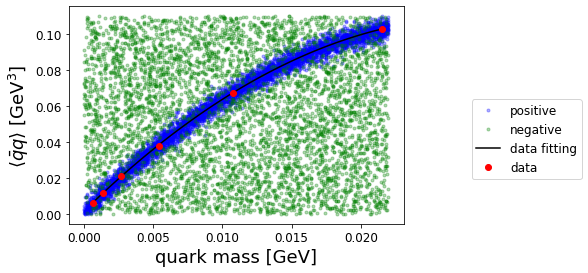

In [13]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [14]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [15]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 4.9074078  -0.54784983  3.1555185   1.8302497   8.880833    2.5825477
  8.985427   -0.42730272  6.770272    4.8754845   2.5025733   5.1884265
  3.15012     3.3455133   4.2671123 ]


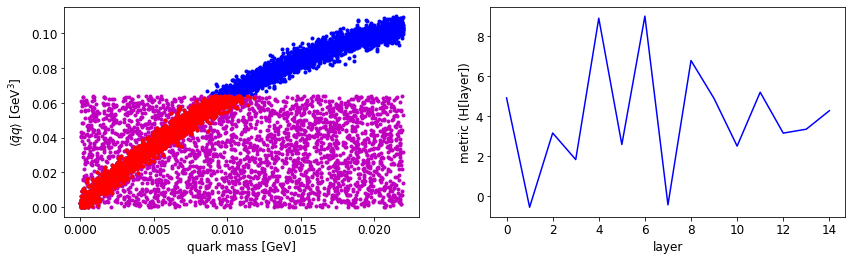

In [26]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [7]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

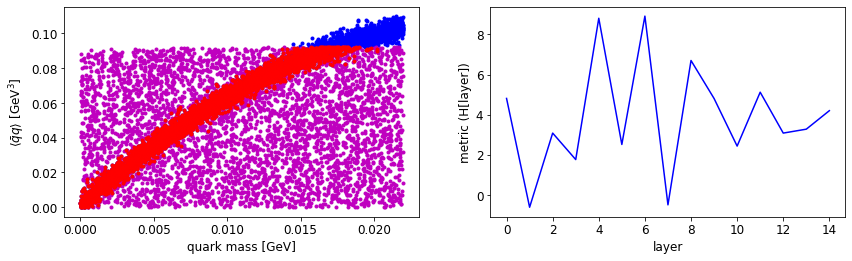

training epoch: 0,   loss: 0.3143077492713928
lambda: 0.11882022023200989,   AdS radius: 0.7289237976074219[1/GeV]
[ 4.80758   -0.6169663  3.0798492  1.759906   8.803751   2.5130074
  8.910619  -0.4974845  6.6980305  4.80437    2.431763   5.117623
  3.0795984  3.27515    4.1969194]


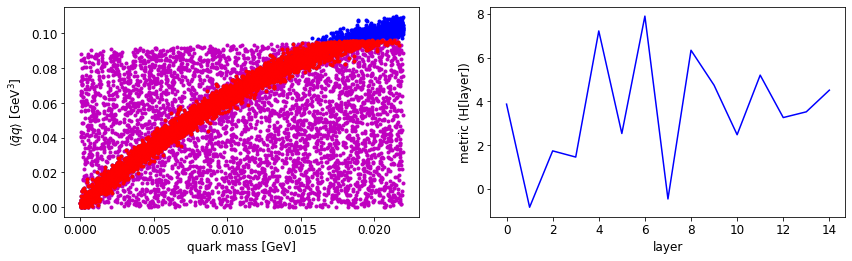

training epoch: 100,   loss: 0.25190383195877075
lambda: -1.8655520677566528,   AdS radius: 0.8352689146995544[1/GeV]
[ 3.869957   -0.8415943   1.7342403   1.4511814   7.2143354   2.5294728
  7.8922606  -0.46328855  6.332256    4.734556    2.4723082   5.1955223
  3.2564037   3.5190246   4.508755  ]


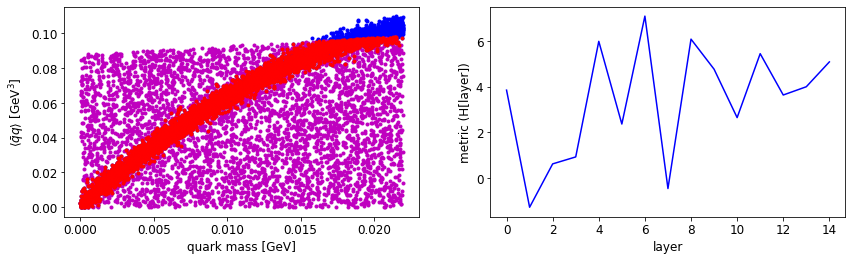

training epoch: 200,   loss: 0.24456846714019775
lambda: -4.2361979484558105,   AdS radius: 0.9438511729240417[1/GeV]
[ 3.8473308  -1.283685    0.616208    0.921404    5.9851036   2.3622925
  7.090292   -0.46354538  6.081543    4.764957    2.6434839   5.4446836
  3.633826    3.9958284   5.0840077 ]


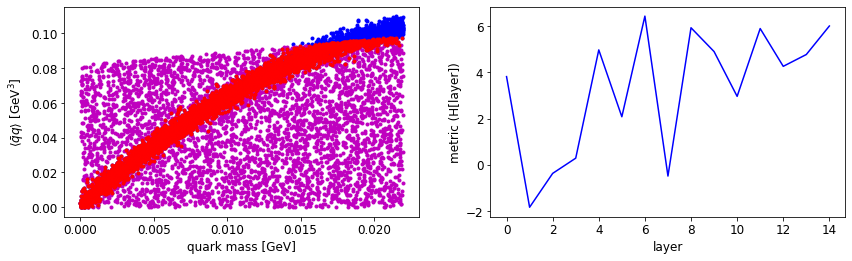

training epoch: 300,   loss: 0.2348727285861969
lambda: -7.045746803283691,   AdS radius: 1.09523344039917[1/GeV]
[ 3.8188376  -1.8345166  -0.36954373  0.28918266  4.974431    2.0817075
  6.436459   -0.48520187  5.932362    4.9023924   2.9640322   5.8982315
  4.2631364   4.774462    6.0085135 ]


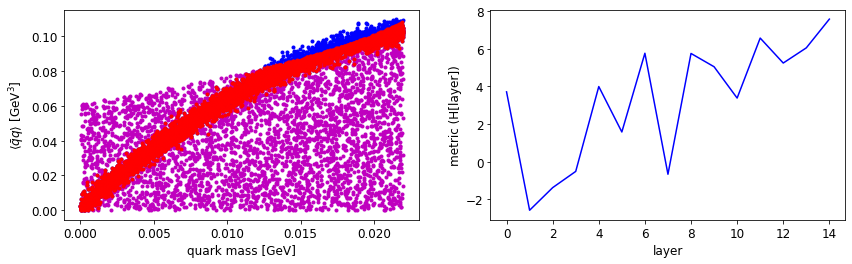

training epoch: 400,   loss: 0.19811269640922546
lambda: -11.02750015258789,   AdS radius: 1.6406043767929077[1/GeV]
[ 3.712484   -2.5875432  -1.3846585  -0.5209557   3.9940076   1.5772086
  5.7661624  -0.67221934  5.7556643   5.048644    3.3812997   6.5743947
  5.2459517   6.053263    7.5827813 ]


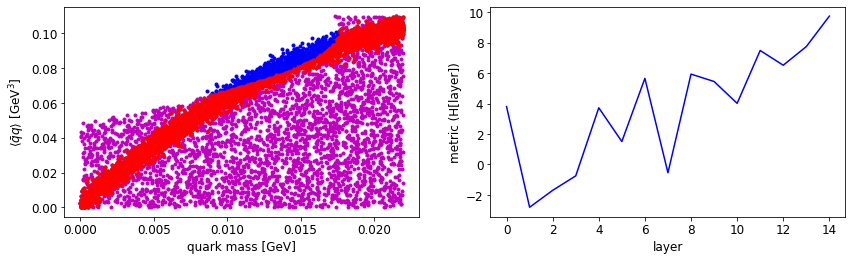

training epoch: 500,   loss: 0.1766154170036316
lambda: -10.697644233703613,   AdS radius: 1.729546308517456[1/GeV]
[ 3.7990968  -2.8089836  -1.6995867  -0.74891305  3.7199023   1.5068147
  5.655071   -0.5458443   5.9332027   5.448153    4.0137963   7.484241
  6.5168605   7.741109    9.741473  ]


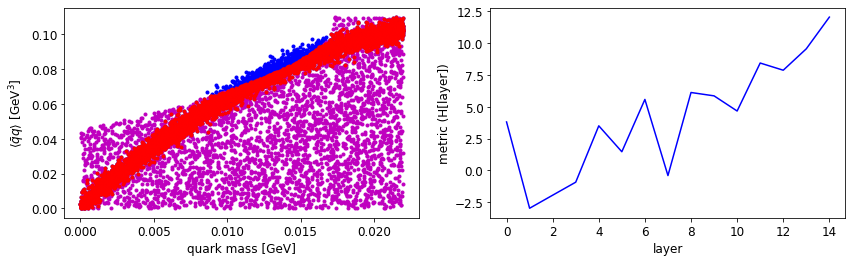

training epoch: 600,   loss: 0.16465479135513306
lambda: -10.07789134979248,   AdS radius: 1.6861581802368164[1/GeV]
[ 3.8131413  -2.9667244  -1.94125    -0.9192173   3.5084958   1.4725345
  5.5827265  -0.39908797  6.127138    5.8624825   4.672141    8.44274
  7.8774858   9.559933   12.049478  ]


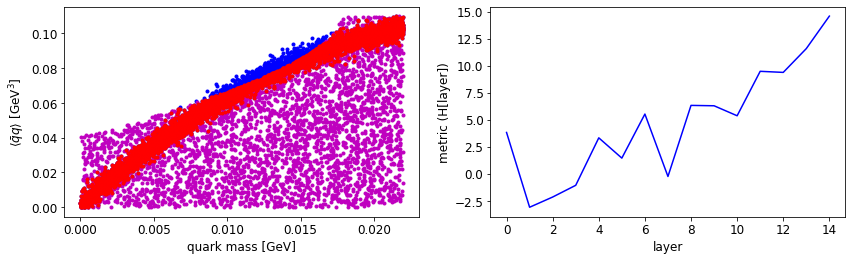

training epoch: 700,   loss: 0.153187096118927
lambda: -9.298802375793457,   AdS radius: 1.6441479921340942[1/GeV]
[ 3.8242047  -3.0883253  -2.144068   -1.0608873   3.326589    1.4533467
  5.524705   -0.24425165  6.326614    6.2910466   5.36769     9.476661
  9.376258   11.575579   14.578514  ]


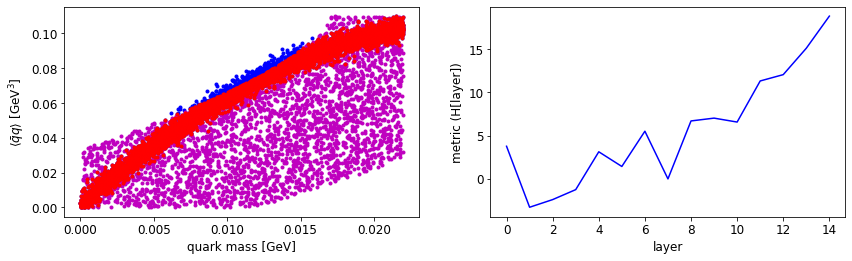

training epoch: 800,   loss: 0.12409030646085739
lambda: -7.592983245849609,   AdS radius: 1.6081918478012085[1/GeV]
[ 3.7676489e+00 -3.2865698e+00 -2.4014628e+00 -1.2483990e+00
  3.1281033e+00  1.4306582e+00  5.5085940e+00 -8.0007995e-03
  6.6969585e+00  7.0226197e+00  6.5675273e+00  1.1321299e+01
  1.2053893e+01  1.5107236e+01  1.8822960e+01]


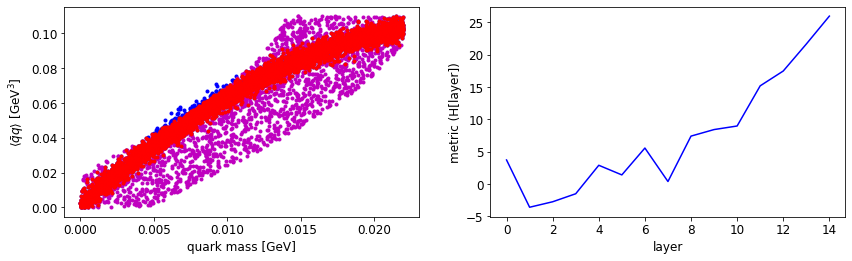

training epoch: 900,   loss: 0.04971543326973915
lambda: -3.4081411361694336,   AdS radius: 1.7051693201065063[1/GeV]
[ 3.7078273  -3.5987332  -2.75122    -1.5129621   2.888186    1.3997188
  5.5510154   0.37883675  7.39678     8.408155    8.959428   15.167097
 17.45771    21.62514    25.942825  ]


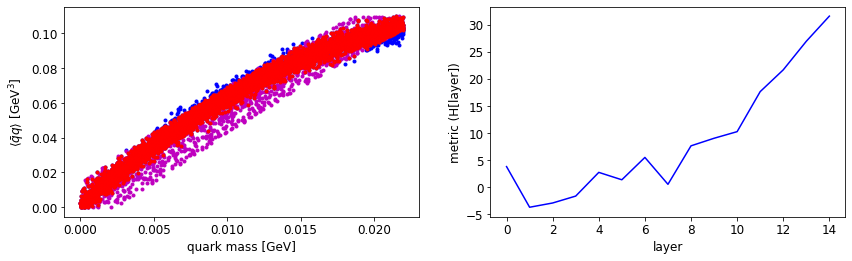

training epoch: 1000,   loss: 0.020032808184623718
lambda: 0.6172730922698975,   AdS radius: 1.8277724981307983[1/GeV]
[ 3.799653  -3.7021632 -2.916141  -1.6409612  2.7324607  1.3659419
  5.492171   0.5302584  7.6301293  9.026674  10.247788  17.631622
 21.649637  26.921795  31.565815 ]


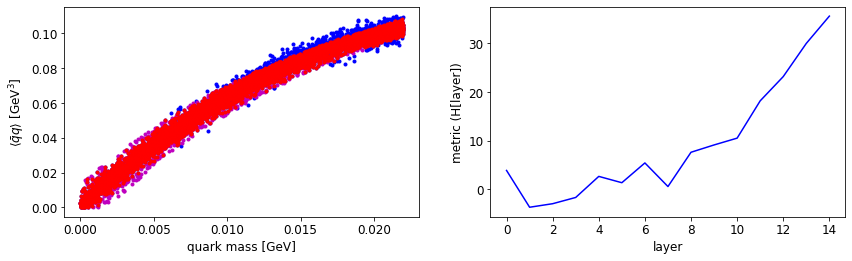

training epoch: 1100,   loss: 0.014155295677483082
lambda: 0.9425747990608215,   AdS radius: 2.087555170059204[1/GeV]
[ 3.8592107  -3.7143466  -2.9858246  -1.6975025   2.6360562   1.3346947
  5.4039273   0.54887646  7.602756    9.106696   10.508522   18.182697
 23.176554   30.005571   35.620636  ]


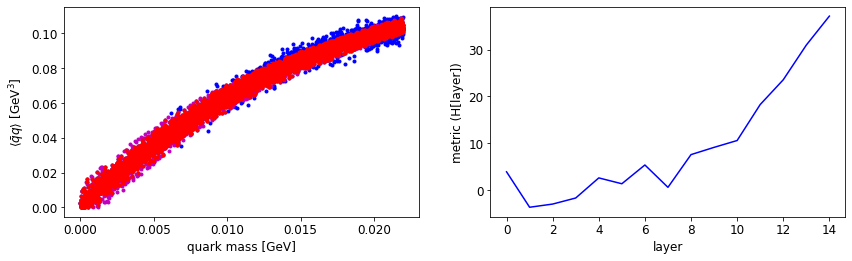

training epoch: 1200,   loss: 0.013897031545639038
lambda: 0.9287048578262329,   AdS radius: 2.087045669555664[1/GeV]
[ 3.8907478 -3.6843917 -3.0046792 -1.7077798  2.5899386  1.3375584
  5.3529696  0.5758729  7.5695577  9.120298  10.584825  18.27394
 23.569527  30.989742  37.18612  ]


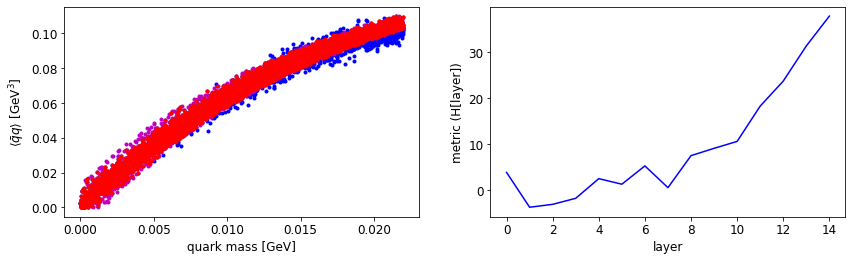

training epoch: 1300,   loss: 0.014033802784979343
lambda: 0.9469967484474182,   AdS radius: 2.073424816131592[1/GeV]
[ 3.9024992 -3.6510952 -3.0183299 -1.7141188  2.548952   1.341739
  5.304723   0.5991194  7.53063    9.115815  10.618904  18.266256
 23.691969  31.303059  37.77214  ]


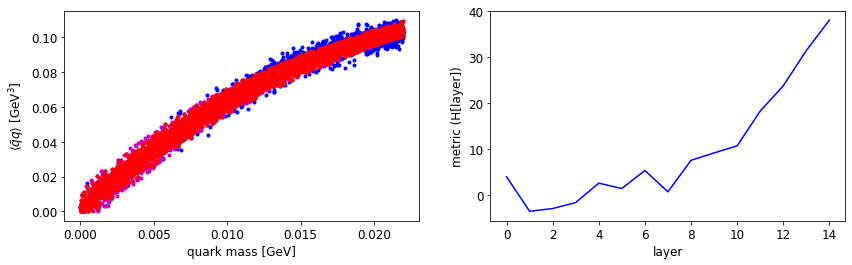

training epoch: 1400,   loss: 0.01414735708385706
lambda: 0.989526629447937,   AdS radius: 2.0671989917755127[1/GeV]
[ 3.910292  -3.6130226 -3.0261092 -1.7152766  2.5140212  1.3502085
  5.262095   0.6252011  7.4950705  9.110949  10.645953  18.238274
 23.746729  31.437368  38.086056 ]


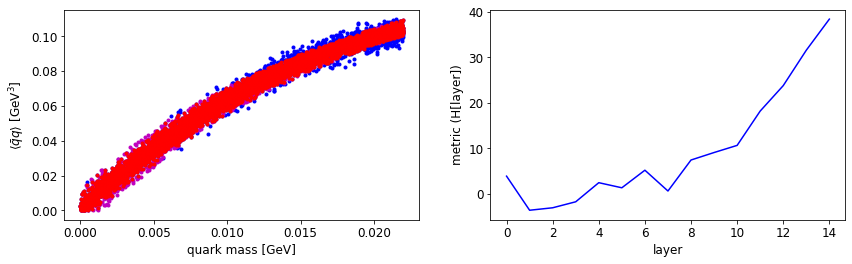

training epoch: 1500,   loss: 0.013581720180809498
lambda: 1.0234276056289673,   AdS radius: 2.0567455291748047[1/GeV]
[ 3.9126644 -3.5768065 -3.0350146 -1.7179697  2.478308   1.3569443
  5.218985   0.6495364  7.459112   9.105169  10.672014  18.213028
 23.805527  31.585169  38.415794 ]


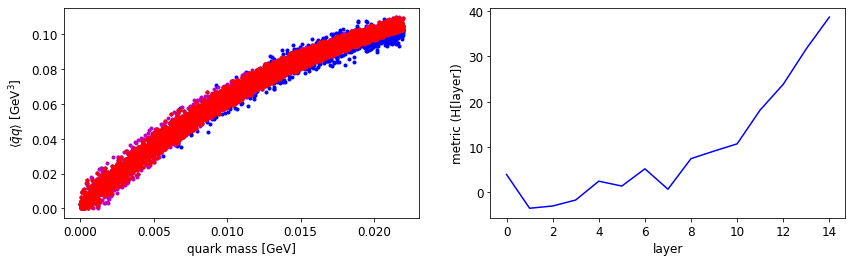

training epoch: 1600,   loss: 0.01381837110966444
lambda: 1.0515482425689697,   AdS radius: 2.0425257682800293[1/GeV]
[ 3.9127758  -3.5415826  -3.0446284  -1.7217065   2.441904    1.3624096
  5.1752706   0.67247534  7.42222     9.097643   10.695374   18.184143
 23.853495   31.707565   38.704544  ]


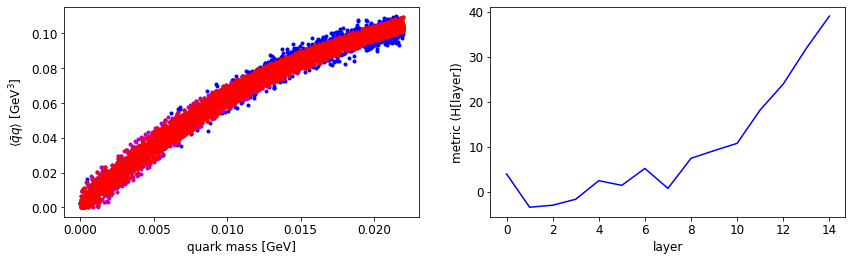

training epoch: 1700,   loss: 0.013567440211772919
lambda: 1.0873486995697021,   AdS radius: 2.0373809337615967[1/GeV]
[ 3.914494   -3.5028174  -3.0519722  -1.7233572   2.406869    1.3701303
  5.1328645   0.69843066  7.3870635   9.0927305  10.722898   18.160988
 23.913895   31.85864    39.0324    ]


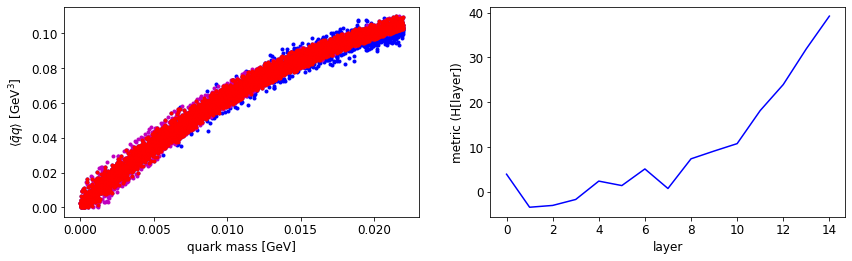

training epoch: 1800,   loss: 0.013244361616671085
lambda: 1.1204506158828735,   AdS radius: 2.0246188640594482[1/GeV]
[ 3.9142044 -3.466076  -3.0608203 -1.7269689  2.370341   1.3754289
  5.088774   0.7213375  7.349138   9.08299   10.742169  18.123318
 23.934471  31.914688  39.2212   ]


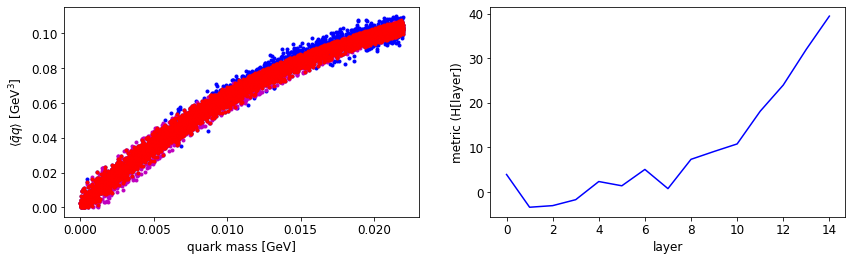

training epoch: 1900,   loss: 0.013825657777488232
lambda: 1.1647074222564697,   AdS radius: 2.019745111465454[1/GeV]
[ 3.9177554 -3.4258215 -3.0653715 -1.7266977  2.3384352  1.3843611
  5.049606   0.7477855  7.316097   9.077576  10.765388  18.092102
 23.961409  31.980461  39.417614 ]


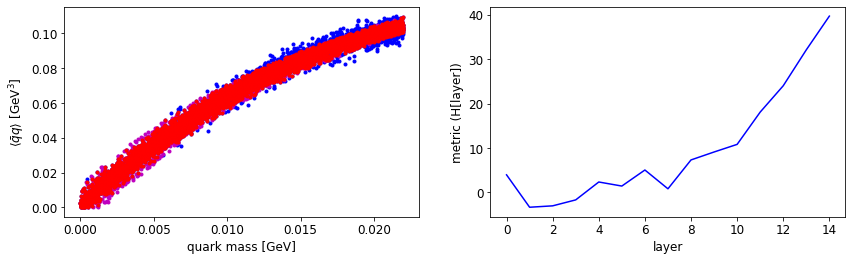

training epoch: 2000,   loss: 0.013212369754910469
lambda: 1.2009220123291016,   AdS radius: 2.0117785930633545[1/GeV]
[ 3.91633   -3.3908148 -3.0744526 -1.7312903  2.302392   1.3883678
  5.0068297  0.7695706  7.280062   9.069412  10.787405  18.067167
 24.008802  32.109837  39.713158 ]


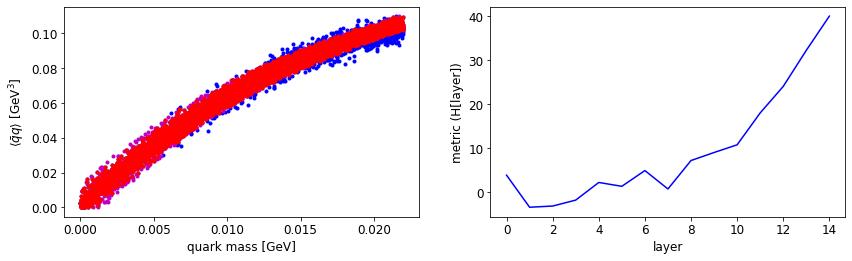

training epoch: 2100,   loss: 0.013104435987770557
lambda: 1.23035728931427,   AdS radius: 1.9996235370635986[1/GeV]
[ 3.9156358 -3.3550918 -3.0826104 -1.735284   2.2672129  1.3928585
  4.9650526  0.7919498  7.2449856  9.061946  10.809938  18.044085
 24.056953  32.24021   40.005154 ]


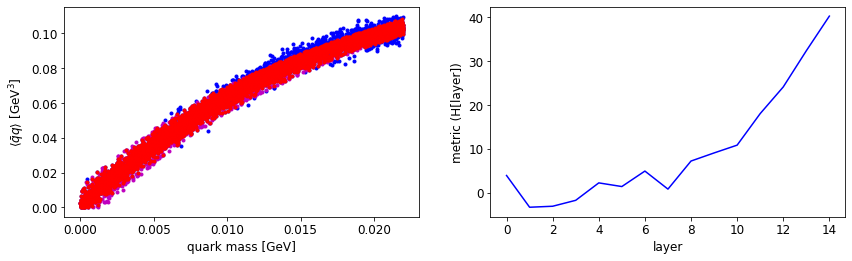

training epoch: 2200,   loss: 0.013153848238289356
lambda: 1.270533800125122,   AdS radius: 1.9945013523101807[1/GeV]
[ 3.9186006 -3.315001  -3.087162  -1.7359725  2.2349281  1.4005443
  4.925965   0.8177071  7.212272   9.056391  10.833585  18.01868
 24.092358  32.330307  40.230732 ]


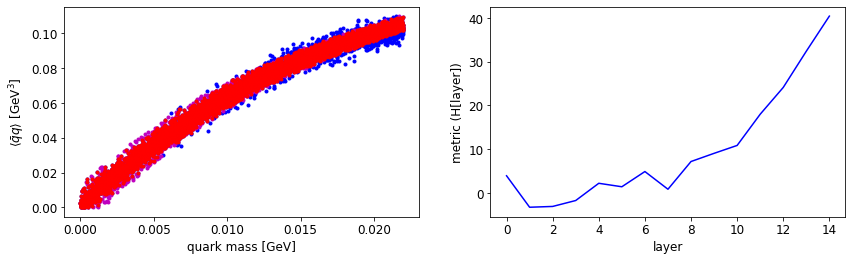

training epoch: 2300,   loss: 0.012982828542590141
lambda: 1.3057864904403687,   AdS radius: 1.9822020530700684[1/GeV]
[ 3.9172091  -3.279262   -3.0956666  -1.7409866   2.1987245   1.4036683
  4.8830266   0.83875155  7.1753535   9.045806   10.85106    17.986238
 24.112932   32.392975   40.421417  ]


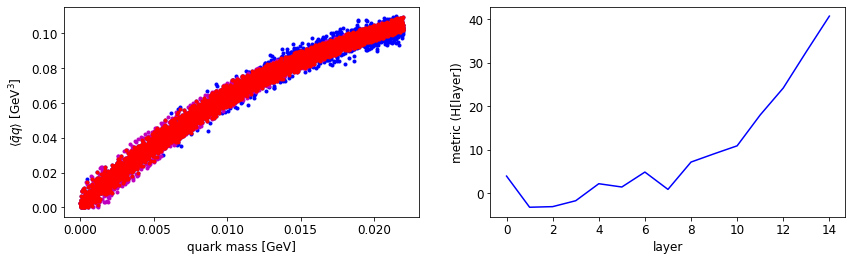

training epoch: 2400,   loss: 0.012656756676733494
lambda: 1.346405029296875,   AdS radius: 1.9780399799346924[1/GeV]
[ 3.917603  -3.2418337 -3.1022222 -1.7443868  2.1644788  1.4083469
  4.842345   0.8616911  7.1412296  9.038292  10.872961  17.963327
 24.153873  32.50582   40.682213 ]


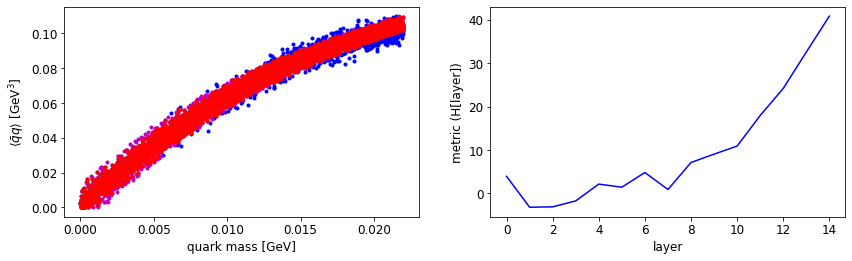

training epoch: 2500,   loss: 0.012628573924303055
lambda: 1.3824294805526733,   AdS radius: 1.9665586948394775[1/GeV]
[ 3.917895  -3.2036996 -3.108385  -1.7477343  2.130134   1.4128335
  4.801361   0.8842913  7.106091   9.028613  10.890521  17.930664
 24.166086  32.546295  40.836533 ]


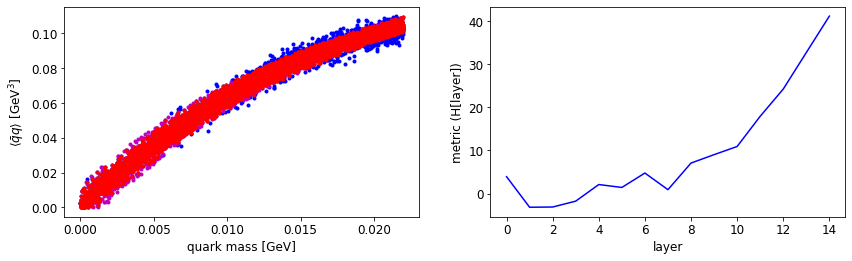

training epoch: 2600,   loss: 0.012580637820065022
lambda: 1.4224069118499756,   AdS radius: 1.9617133140563965[1/GeV]
[ 3.9186895  -3.166073   -3.1138713  -1.7507553   2.0971484   1.4176109
  4.762391    0.90747756  7.0739117   9.022461   10.914058   17.914564
 24.217781   32.68784    41.130566  ]


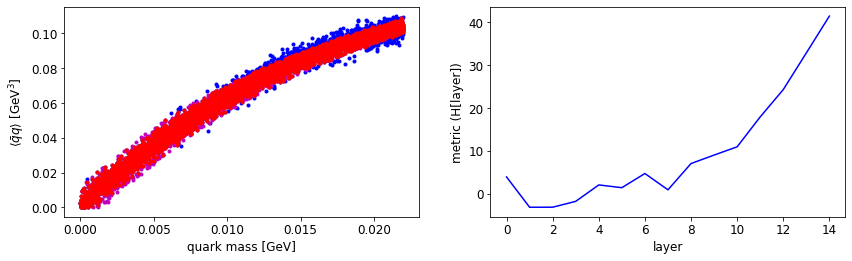

training epoch: 2700,   loss: 0.012564275413751602
lambda: 1.4618483781814575,   AdS radius: 1.9572489261627197[1/GeV]
[ 3.9198647 -3.1277428 -3.1189678 -1.7537329  2.0641048  1.4221953
  4.7232075  0.9304148  7.0409484  9.014755  10.934531  17.891722
 24.24973   32.78023   41.356403 ]


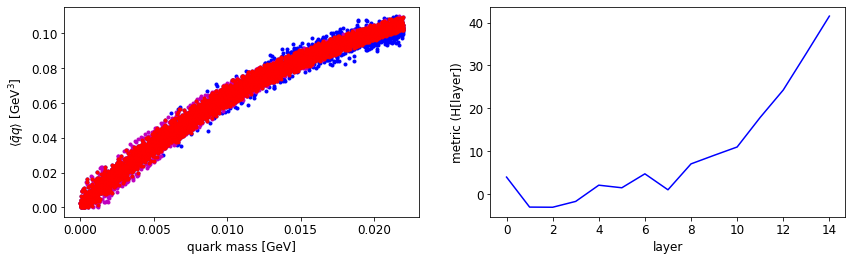

training epoch: 2800,   loss: 0.012726465240120888
lambda: 1.4931769371032715,   AdS radius: 1.9436585903167725[1/GeV]
[ 3.9193532 -3.0910797 -3.1252868 -1.7582908  2.0298305  1.424972
  4.682899   0.9514041  7.0065203  9.004715  10.951396  17.864017
 24.267828  32.839207  41.533405 ]


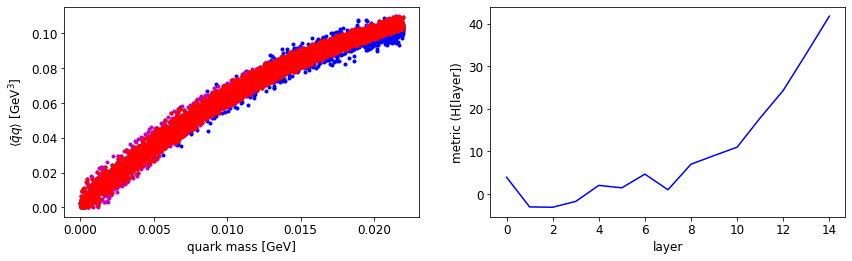

training epoch: 2900,   loss: 0.012549985200166702
lambda: 1.533739686012268,   AdS radius: 1.9369724988937378[1/GeV]
[ 3.9189398 -3.0544846 -3.1311774 -1.7627887  1.9960761  1.4276353
  4.6432977  0.9723205  6.9729548  8.995254  10.9691305 17.83994
 24.292944  32.917755  41.73562  ]


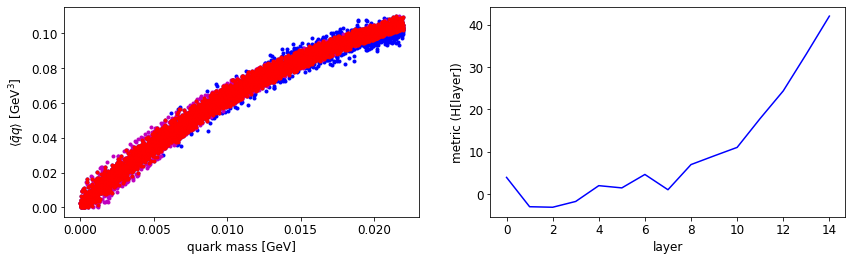

training epoch: 3000,   loss: 0.0713248997926712
lambda: 1.571049690246582,   AdS radius: 1.9308815002441406[1/GeV]
[ 3.9126203 -3.0123272 -3.135359  -1.7658079  1.9612978  1.4323422
  4.602328   0.9972336  6.9388046  8.987441  10.991594  17.819563
 24.330568  33.025967  41.982635 ]


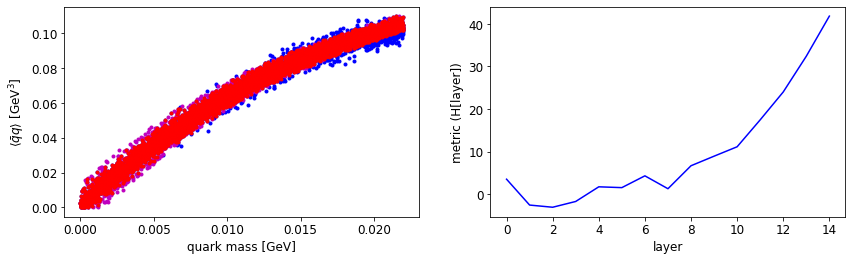

training epoch: 3100,   loss: 0.06031071022152901
lambda: 1.5960965156555176,   AdS radius: 1.9276612997055054[1/GeV]
[ 3.4892602 -2.59531   -3.1083682 -1.7486216  1.6968551  1.5053762
  4.2780848  1.247287   6.6549935  8.901514  11.115349  17.450165
 24.007147  32.413754  41.84594  ]


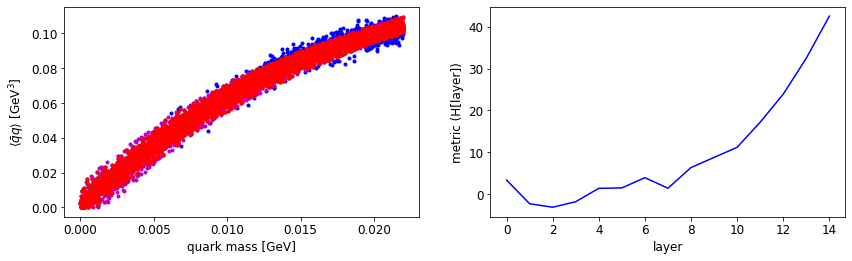

training epoch: 3200,   loss: 0.05447671562433243
lambda: 1.5904552936553955,   AdS radius: 1.9231621026992798[1/GeV]
[ 3.3896363 -2.2499158 -3.093333  -1.7729846  1.4226282  1.5203302
  3.9590294  1.4425148  6.3803244  8.79592   11.211996  17.202202
 23.884687  32.457794  42.510437 ]


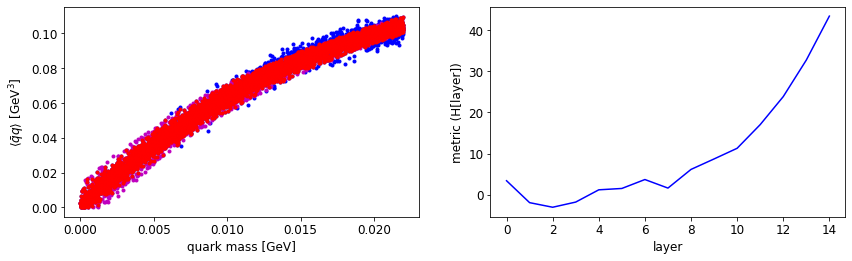

training epoch: 3300,   loss: 0.05039188265800476
lambda: 1.5774476528167725,   AdS radius: 1.9258571863174438[1/GeV]
[ 3.3827267 -1.9550418 -3.0722678 -1.8128622  1.1708326  1.5021238
  3.675921   1.594527   6.14028    8.689907  11.284351  17.042673
 23.86834   32.766968  43.47118  ]


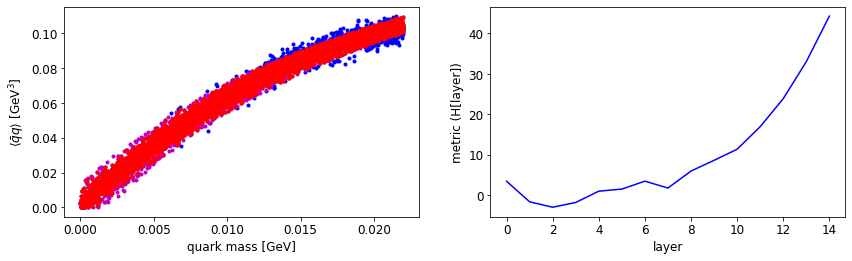

training epoch: 3400,   loss: 0.046588703989982605
lambda: 1.551863670349121,   AdS radius: 1.9206207990646362[1/GeV]
[ 3.401954  -1.6846179 -3.0363069 -1.8551825  0.9417298  1.4662232
  3.424108   1.7207626  5.928495   8.583821  11.332697  16.91618
 23.846346  33.025845  44.304977 ]


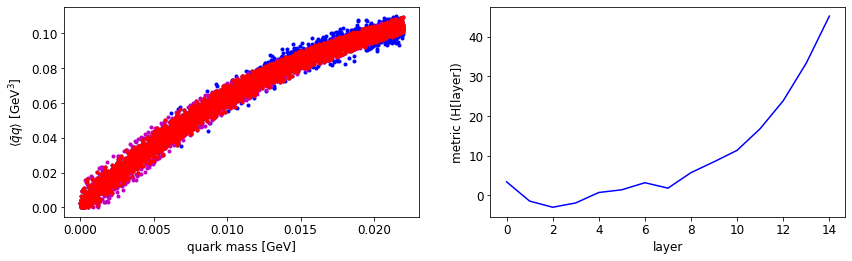

training epoch: 3500,   loss: 0.04397836700081825
lambda: 1.5308797359466553,   AdS radius: 1.9260319471359253[1/GeV]
[ 3.4261222 -1.4335247 -2.9875066 -1.899119   0.729347   1.4153905
  3.1959155  1.8263949  5.73963    8.480665  11.369216  16.830559
 23.870504  33.363285  45.205345 ]


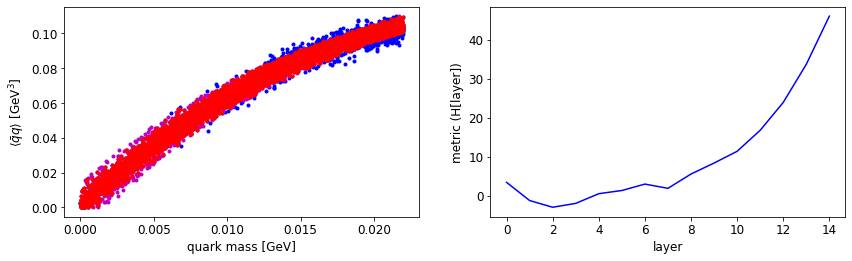

training epoch: 3600,   loss: 0.04107161611318588
lambda: 1.4985287189483643,   AdS radius: 1.9237645864486694[1/GeV]
[ 3.449731  -1.2099279 -2.9288585 -1.9392004  0.5429055  1.3573079
  2.9992528  1.9111358  5.5792284  8.385468  11.392569  16.771204
 23.903738  33.665485  46.001694 ]


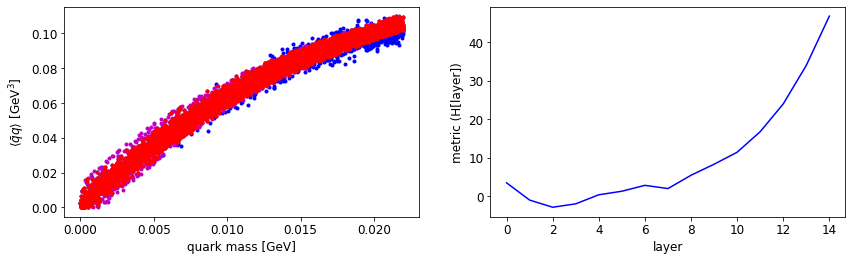

training epoch: 3700,   loss: 0.03898847848176956
lambda: 1.4671270847320557,   AdS radius: 1.923501968383789[1/GeV]
[ 3.4716778  -1.002438   -2.860969   -1.9773072   0.37012318  1.2910552
  2.8196871   1.9807705   5.4345016   8.292241   11.4044895  16.724472
 23.93527    33.92417    46.698338  ]


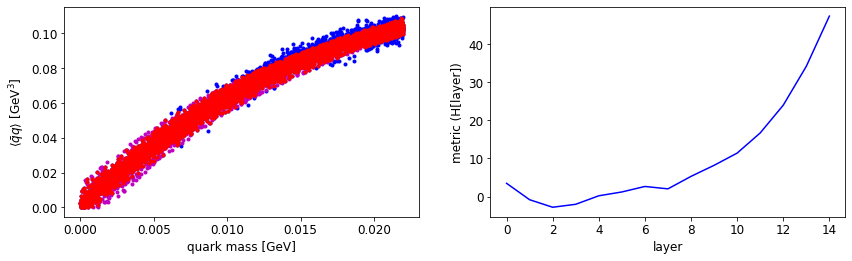

training epoch: 3800,   loss: 0.037204839289188385
lambda: 1.4401166439056396,   AdS radius: 1.9278074502944946[1/GeV]
[ 3.4948518  -0.8127798  -2.78429    -2.0077205   0.21880805  1.2248791
  2.6643198   2.039476    5.311956    8.209078   11.412763   16.69637
 23.979702   34.174442   47.339756  ]


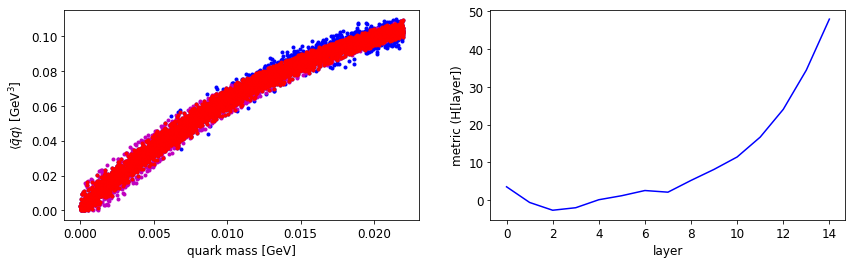

training epoch: 3900,   loss: 0.035582393407821655
lambda: 1.4044678211212158,   AdS radius: 1.9294941425323486[1/GeV]
[ 3.513182   -0.6423248  -2.7058938  -2.037095    0.07807887  1.153098
  2.5213702   2.084242    5.200726    8.128655   11.413992   16.67901
 24.035353   34.42846    47.962196  ]


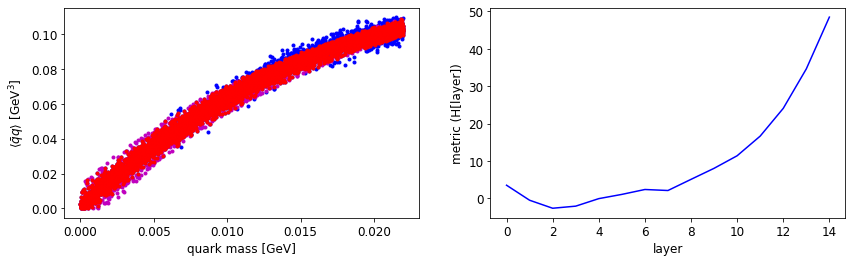

training epoch: 4000,   loss: 0.034643352031707764
lambda: 1.3695470094680786,   AdS radius: 1.9325391054153442[1/GeV]
[ 3.5309618  -0.48402897 -2.6225758  -2.0619614  -0.05142894  1.0795869
  2.3905334   2.120321    5.1004167   8.051792   11.409644   16.665205
 24.083092   34.633686   48.48082   ]


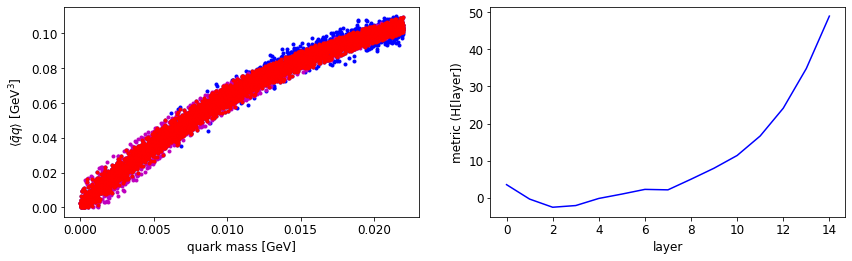

training epoch: 4100,   loss: 0.03302168846130371
lambda: 1.3329423666000366,   AdS radius: 1.9335500001907349[1/GeV]
[ 3.5463712  -0.34127796 -2.5387332  -2.083136   -0.16946256  1.0056776
  2.2717187   2.1473756   5.010738    7.979688   11.401565   16.656843
 24.131523   34.820747   48.940197  ]


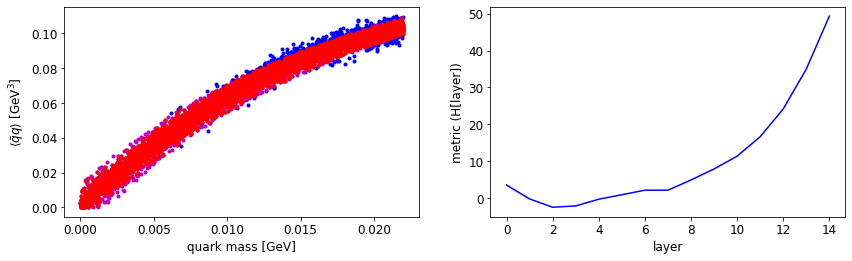

training epoch: 4200,   loss: 0.03175918757915497
lambda: 1.302303671836853,   AdS radius: 1.9384701251983643[1/GeV]
[ 3.5608497  -0.21082523 -2.4540362  -2.0996885  -0.27647153  0.93309695
  2.1639597   2.1678133   4.930592    7.912303   11.3902645  16.649906
 24.172153   34.973984   49.323235  ]


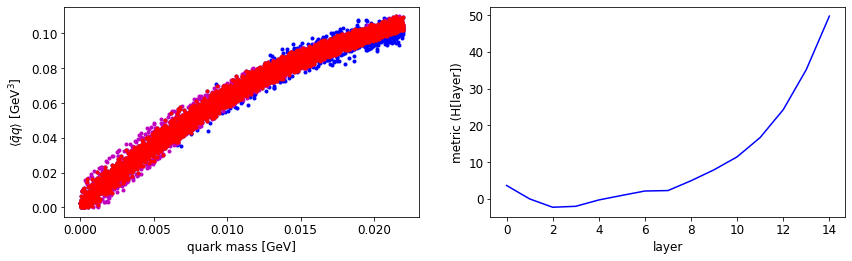

training epoch: 4300,   loss: 0.03091677650809288
lambda: 1.2587076425552368,   AdS radius: 1.9407716989517212[1/GeV]
[ 3.572642   -0.08852044 -2.368069   -2.115248   -0.3809451   0.8563298
  2.058751    2.1813402   4.853748    7.845819   11.3778925  16.651794
 24.233294   35.167725   49.744938  ]


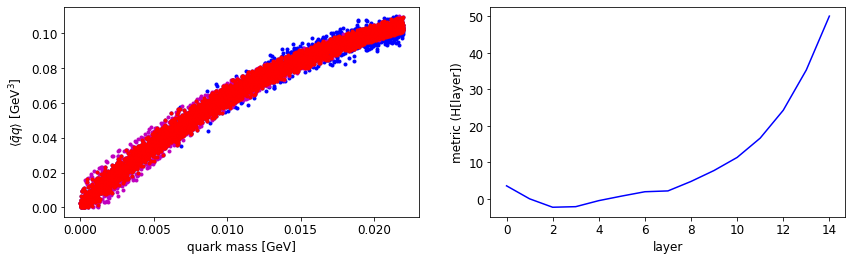

training epoch: 4400,   loss: 0.030411608517169952
lambda: 1.2227685451507568,   AdS radius: 1.9454256296157837[1/GeV]
[ 3.5854919e+00  2.3094371e-02 -2.2827144e+00 -2.1246574e+00
 -4.7256306e-01  7.8490621e-01  1.9659094e+00  2.1915278e+00
  4.7873158e+00  7.7864137e+00  1.1365296e+01  1.6654760e+01
  2.4285244e+01  3.5321011e+01  5.0083176e+01]


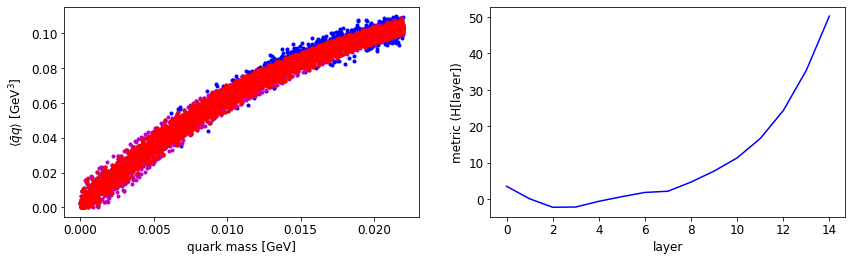

training epoch: 4500,   loss: 0.22416625916957855
lambda: 1.18711519241333,   AdS radius: 1.9525517225265503[1/GeV]
[ 3.5619082   0.1406199  -2.1853955  -2.1262562  -0.55998397  0.71305346
  1.8760594   2.2019267   4.72423     7.726999   11.348649   16.649126
 24.302446   35.359203   50.232533  ]


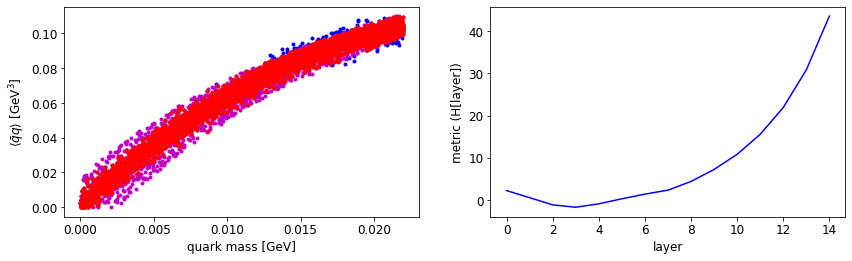

training epoch: 4600,   loss: 0.13290774822235107
lambda: 0.8919658064842224,   AdS radius: 2.0102179050445557[1/GeV]
[ 2.2448564   0.5586384  -1.1409409  -1.7079128  -0.90083677  0.2935061
  1.4014608   2.3434129   4.401311    7.242647   10.8295355  15.569891
 21.915577   30.82806    43.57618   ]


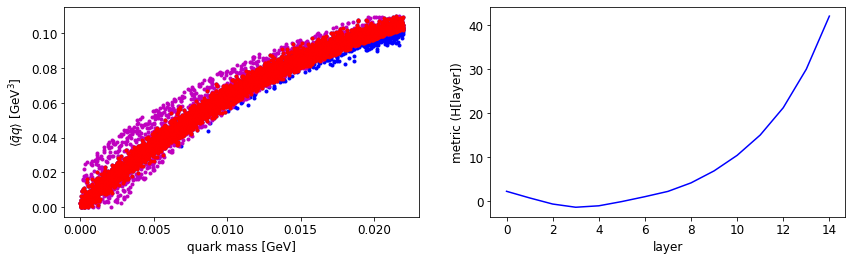

training epoch: 4700,   loss: 0.11743316054344177
lambda: 0.4376641511917114,   AdS radius: 2.214573860168457[1/GeV]
[ 2.210268    0.7057531  -0.68323594 -1.4126517  -1.0861595  -0.11873428
  0.99074316  2.1920285   4.1249886   6.8491845  10.381859   14.994337
 21.205969   29.966545   42.02932   ]


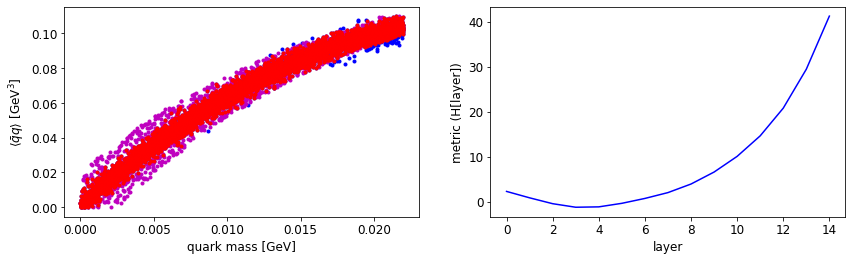

training epoch: 4800,   loss: 0.11001598089933395
lambda: 0.14527273178100586,   AdS radius: 2.5146803855895996[1/GeV]
[ 2.2818341   0.8568942  -0.44545373 -1.234191   -1.1498542  -0.36235505
  0.722764    2.0200653   3.9241796   6.5835347  10.067724   14.626395
 20.779303   29.427715   41.22851   ]


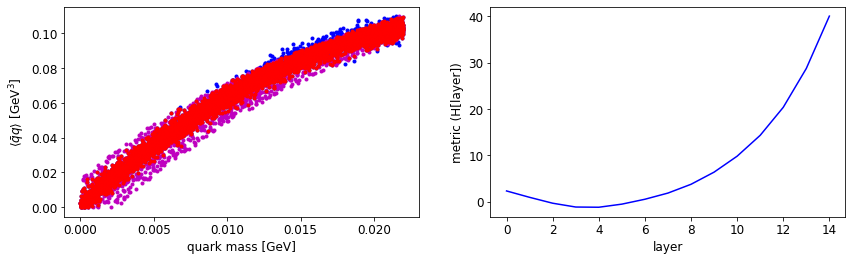

training epoch: 4900,   loss: 0.10343140363693237
lambda: 0.051804106682538986,   AdS radius: 2.827887773513794[1/GeV]
[ 2.3426676   0.9658175  -0.3018232  -1.1248236  -1.1706004  -0.50117296
  0.5526024   1.8851978   3.7781718   6.3971953   9.837129   14.334475
 20.370886   28.752167   40.038937  ]


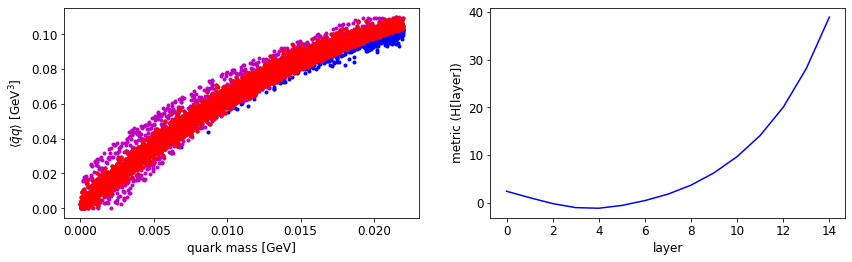

training epoch: 5000,   loss: 0.10000595450401306
lambda: 0.026069292798638344,   AdS radius: 3.0831944942474365[1/GeV]
[ 2.3852625   1.0423934  -0.20505144 -1.0514283  -1.1804013  -0.5946134
  0.429306    1.7759109   3.6614473   6.25157     9.653508   14.091593
 20.009068   28.1328     38.918125  ]


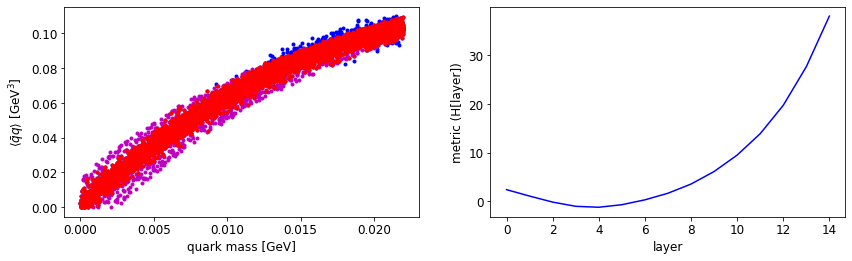

training epoch: 5100,   loss: 0.09727276861667633
lambda: 0.018171461299061775,   AdS radius: 3.263274669647217[1/GeV]
[ 2.4239342   1.107805   -0.12500237 -0.9887969  -1.1781775  -0.6571819
  0.33925596  1.690964    3.570283    6.137837    9.507165   13.892078
 19.704346   27.611803   37.98812   ]


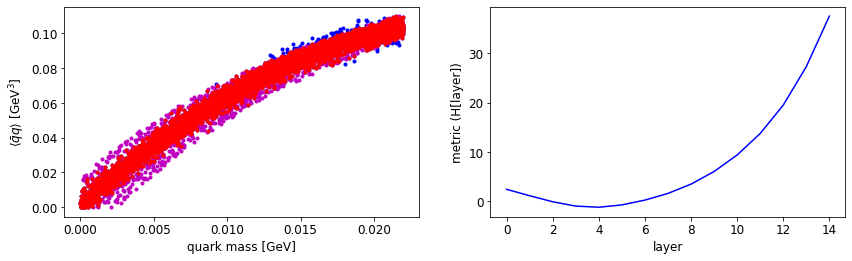

training epoch: 5200,   loss: 0.09550365805625916
lambda: 0.013110345229506493,   AdS radius: 3.3731703758239746[1/GeV]
[ 2.4525657   1.1573558  -0.06426621 -0.9408035  -1.1744859  -0.70323044
  0.26964247  1.6222508   3.4967291   6.0476503   9.392215   13.73742
 19.477226   27.260448   37.478214  ]


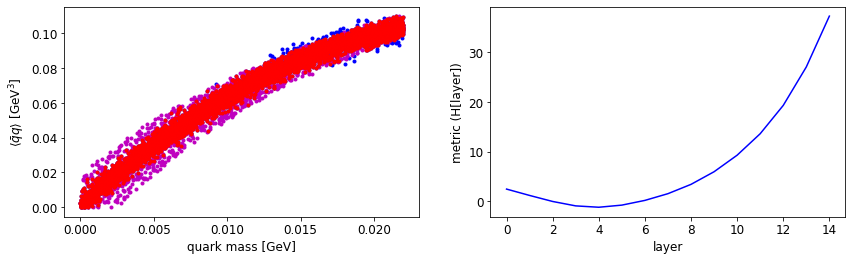

training epoch: 5300,   loss: 0.09428122639656067
lambda: 0.010635842569172382,   AdS radius: 3.454857349395752[1/GeV]
[ 2.4781914e+00  1.2020504e+00 -9.3150102e-03 -8.9678121e-01
 -1.1691130e+00 -7.4284208e-01  2.0691043e-01  1.5582273e+00
  3.4283535e+00  5.9651842e+00  9.2886992e+00  1.3602046e+01
  1.9291742e+01  2.7017735e+01  3.7232674e+01]


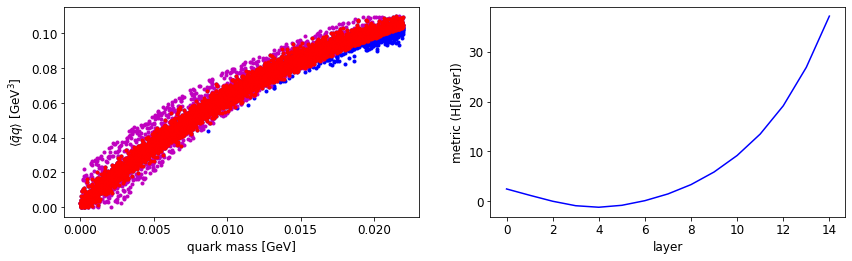

training epoch: 5400,   loss: 0.09237107634544373
lambda: 0.008371694944798946,   AdS radius: 3.5120677947998047[1/GeV]
[ 2.4992778   1.2396753   0.03730066 -0.85908943 -1.1637379  -0.77627945
  0.15209949  1.500623    3.36681     5.892008    9.198069   13.486315
 19.142208   26.845772   37.100765  ]


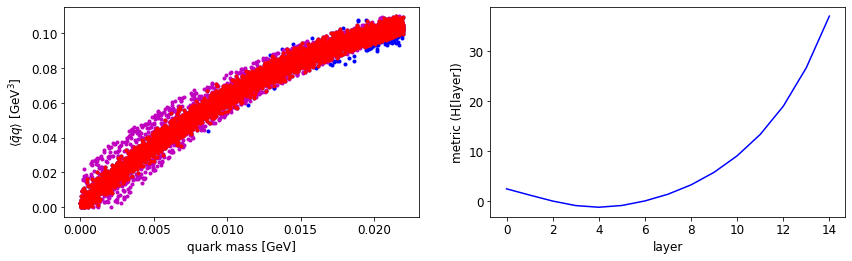

training epoch: 5500,   loss: 0.09405802935361862
lambda: 0.009168398566544056,   AdS radius: 3.556368827819824[1/GeV]
[ 2.519943    1.2758893   0.08211716 -0.82219523 -1.1563925  -0.8054555
  0.10160454  1.4460692   3.3083158   5.8230133   9.113437   13.38047
 19.012863   26.71524    37.026478  ]


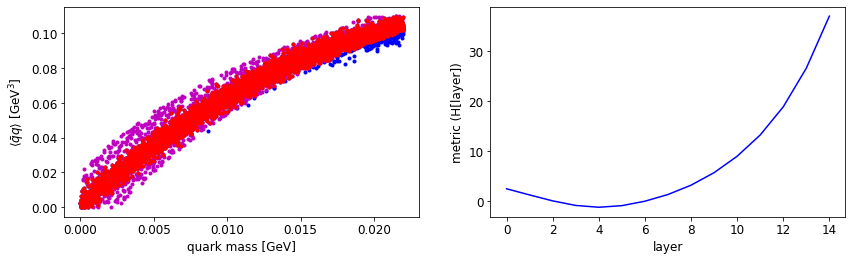

training epoch: 5600,   loss: 0.09137387573719025
lambda: 0.007858030498027802,   AdS radius: 3.587491273880005[1/GeV]
[ 2.5388722   1.3090457   0.12327996 -0.787836   -1.148341   -0.8307876
  0.05575936  1.395311    3.2537763   5.759308    9.036378   13.286644
 18.90592    26.626457   37.03153   ]


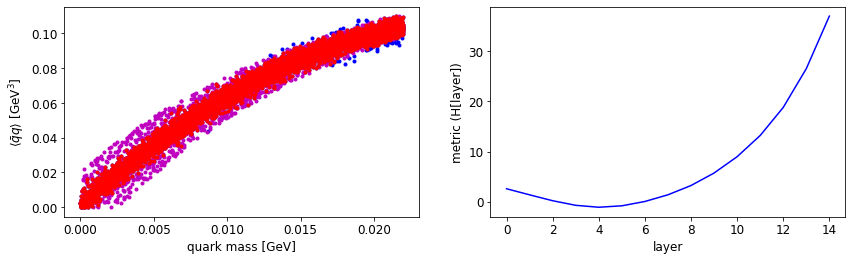

training epoch: 5700,   loss: 0.08999607712030411
lambda: 0.007364748977124691,   AdS radius: 3.6219141483306885[1/GeV]
[ 2.5571086e+00  1.3404456e+00  1.6219853e-01 -7.5485921e-01
 -1.1391666e+00 -8.5256553e-01  1.4060055e-02  1.3479739e+00
  3.2026472e+00  5.6999221e+00  8.9651670e+00  1.3201839e+01
  1.8814060e+01  2.6560785e+01  3.7063366e+01]


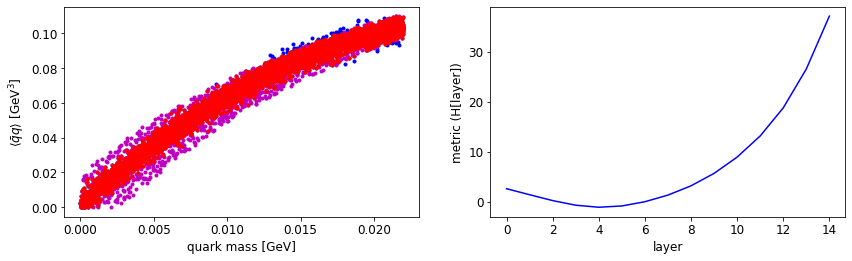

training epoch: 5800,   loss: 0.08860775083303452
lambda: 0.006417587399482727,   AdS radius: 3.639380931854248[1/GeV]
[ 2.5749345e+00  1.3708223e+00  1.9992557e-01 -7.2246522e-01
 -1.1290935e+00 -8.7222362e-01 -2.5564956e-02  1.3019300e+00
  3.1526349e+00  5.6421623e+00  8.8964567e+00  1.3121546e+01
  1.8730902e+01  2.6506618e+01  3.7072861e+01]


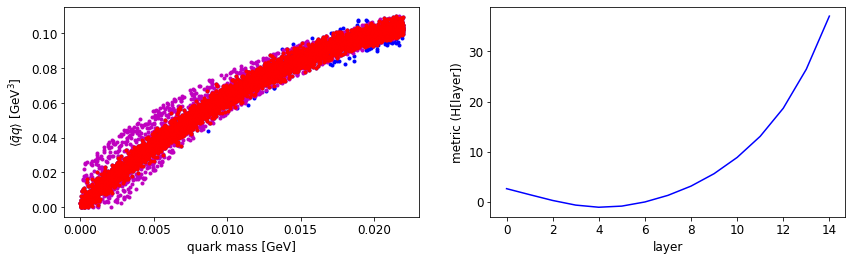

training epoch: 5900,   loss: 0.09051389992237091
lambda: 0.008316596038639545,   AdS radius: 3.636155843734741[1/GeV]
[ 2.5891974   1.3971866   0.2334488  -0.6937049  -1.1212304  -0.89284766
 -0.06610245  1.2542512   3.1007416   5.582844    8.826867   13.041534
 18.649292   26.448977   37.058784  ]


In [27]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)